In [1]:
# !usr/bin/python
# -*- encoding: utf-8 -*-
# Project: Deep Residual Learning 
# Author: Tracy Tao
# Date: 2022/04/12
import torch 
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

- 核心思想是：每个附加层都应该更容易地包含原始函数作为其元素之一
- 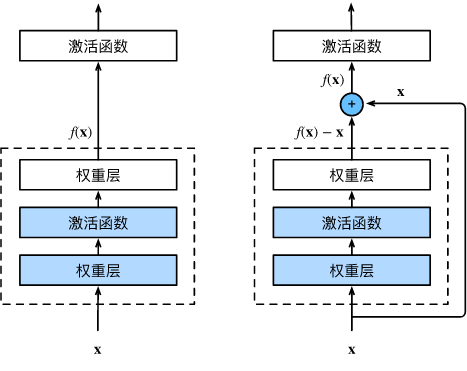
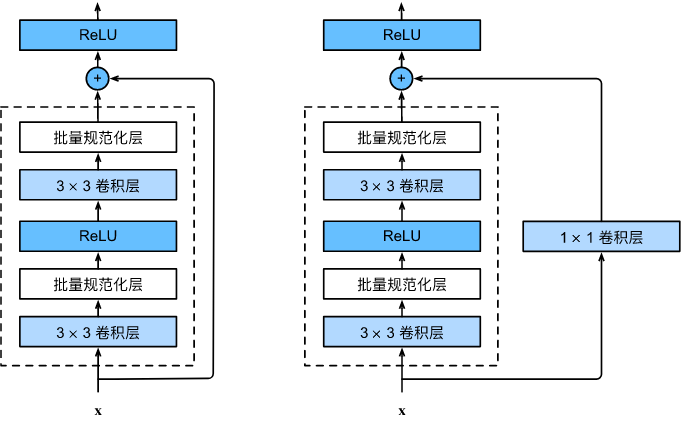
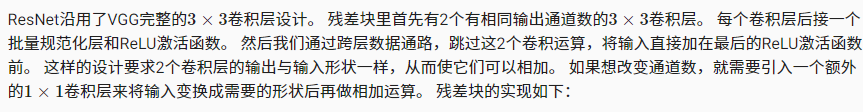

In [7]:
class Residual(nn.Module): #@save
    def __init__(self, input_channels, num_channels, use_1x1conv = False, strides=1):
        '''
        :param input_channels: input X
        :param num_channels: output X'
        :param use_1x1conv: 是否要使用1*1 Conv2d改变通道数（形状）
        '''
        super().__init__()
        # 使用两个2*2Conv
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size = 3, padding =1, stride = strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size = 3, padding =1)
        if use_1x1conv:  # 如果使用1*1 conv(跨层部分），保持通道数相同
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size =1, stride = strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X))) # 对第一个卷积输出进行BN和relu
        Y = self.bn2(self.conv2(Y)) # 对Y进行第二个卷积运算并BN
        if self.conv3:
            X = self.conv3(X) # 跨层卷积
        Y += X #汇总
        return F.relu(Y) # 对残差块输出进行relu
            


In [8]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [9]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

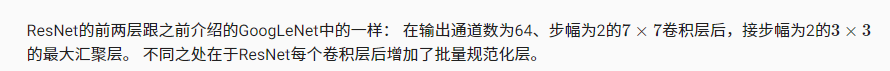

In [10]:
# ResNet
b1 = nn.Sequential(nn.Conv2d(1,64, kernel_size =7, stride =2, padding =3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size =3, stride =3, padding=1))

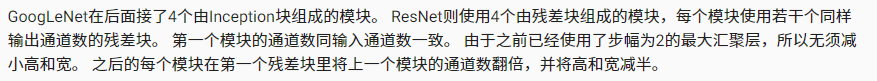

In [11]:
def resnet_block(input_channels, num_channels, num_residuals, first_block = False):
    blk = []
    for i in range(num_residuals):
        if i ==0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv = True, strides =2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [12]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [13]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512,10))

- 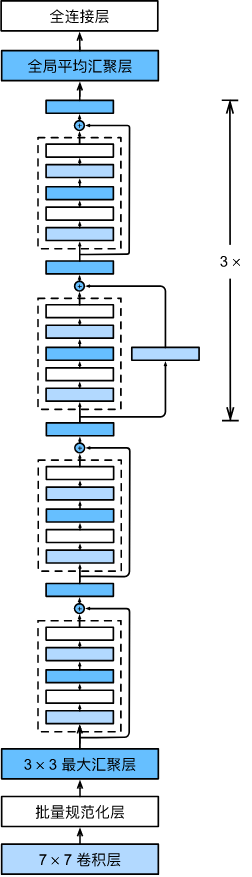
-  在之前所有架构中，分辨率降低，通道数量增加，直到全局平均汇聚层聚集所有特征。

In [14]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 38, 38])
Sequential output shape:	 torch.Size([1, 64, 38, 38])
Sequential output shape:	 torch.Size([1, 128, 19, 19])
Sequential output shape:	 torch.Size([1, 256, 10, 10])
Sequential output shape:	 torch.Size([1, 512, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


- 利用残差块（residual blocks）可以训练出一个有效的深层神经网络：输入可以通过层间的残余连接更快地向前传播。残差映射可以更容易地学习同一函数，例如将权重层中的参数近似为零。